# Introduction

Impact analysis of CMA-ES modules on black-box optimization tasks.

This Python Notebook records the data analysis that was performed for the paper **Algorithm Configuration Data Mining for CMA Evolution Strategies** by **Sander van Rijn, Hao Wang, Bas van Stein and Thomas Bäck**, currently under submission. The dataset consisting of pre-processed .arff files has been generated as part of a previous paper **Evolving the Structure of Evolution Strategies** by **Sander van Rijn, Hao Wang, Matthijs van Leeuwen and Thomas Bäck**.


## Data Format

Filenames follow the format:

    bruteforce_<D>_f<F>.arff

    | Description          | Values           |
    |----------------------|------------------|
    | Dimensionality <D>   | 2, 3, 5, 10, 20  |
    | BBOB Function ID <F> | 1, 2, 3, ..., 24 |


Data entries consist of a configuration specification $c \in \{0,1\}^9 \times \{0,1,2\}^2$ and associated quality measure $q \in [0, 2]$.
Using SciPy's included `arff` reader, the data can easily be read in.


    Configuration (1-11)  | q-measure
    ----------------------+-----------------
    0,0,0,0,0,0,0,0,0,0,0 | 0.00573046875
    0,0,0,0,0,0,0,0,0,0,1 | 0.00549609375
    0,0,0,0,0,0,0,0,0,0,2 | 0.005490234375
    0,0,0,0,0,0,0,0,0,1,0 | 0.0044736328125
    [...]                 | [...]
    1,1,1,1,1,1,1,1,1,1,2 | 0.0120693359375
    1,1,1,1,1,1,1,1,1,2,0 | 0.240296875
    1,1,1,1,1,1,1,1,1,2,1 | 0.0112963867188
    1,1,1,1,1,1,1,1,1,2,2 | 0.0117387695313

## Author

Sander van Rijn &lt;svr003@gmail.com; s.j.van.rijn@liacs.leidenuniv.nl&gt; <br>
Last update: 2017-02-09

# Initialization

First cell to be run, containing all imports and default settings to be used throughout the rest of this notebook.

Some data-specific information is also pre-set here, such as the input file format, list of dimensionalities, BBOB function ID's and module names.

In [1]:
# Imports + definitions

%matplotlib inline
# %matplotlib notebook

from __future__ import division, print_function

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import networkx as nx
import numpy as np
import os
import pydotplus
import scipy.io.arff as arff

from collections import Counter
from cycler import cycler
from IPython.display import Image
from itertools import combinations, product
from matplotlib import gridspec
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu, truncnorm
from scipy.stats.stats import pearsonr
from sklearn import tree
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score



# os.chdir('/media/Data/Research Data/Evolving ES data/')
os.chdir('C:\\Users\\Sander\\surfdrive\\Research Data\\Evolving the Structure of Evolution Strategies\\experiments\\BF runs')

data_dir = 'arff/'
plot_dir = 'plots/'
plot_format = 'png'  # Suggested: 'png' for fixed images, 'pdf' for vector graphics

np.set_printoptions(precision=4, linewidth=200)
plt.rc('axes', prop_cycle=(cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', 
                                            '#d62728', '#9467bd', '#8c564b', 
                                            '#e377c2', '#7f7f7f', '#bcbd22', 
                                            '#1f77b4', '#ff7f0e']) +
                           cycler('linestyle', ['-', '-', '-', 
                                                '-', '-', '-', 
                                                '-', '-', '-', 
                                                '--', '--'])))

fname = 'bruteforce_{}_f{}.arff'
dims = [2, 3, 5, 10, 20]
fids = range(1, 25)
experiments = product(dims, fids)
modules = ['Active', 'Elitism', 'Mirrored', 'Orthogonal', 'Sequential', 'Threshold', 'TPA', 'Pairwise', 'Weights', 'Base-Sampler', '(B)IPOP']

In [2]:
# Load all data from files into 'cases'

cases = {dim: {} for dim in dims}

for dim in dims:
    for fid in fids:
        case = arff.loadarff(data_dir + fname.format(dim, fid))[0]
        case = np.array([list(dat) for dat in case])
        cases[dim][fid] = case

# Plotting the $q$-measure

Just to give an idea of what data we're dealing with: lets plot the data we have.

The cell below creates a graph for each of the 24 functions in the BBOB suite.
For each dimensionality, all 4608 $q$-measure values are plotted, sorted by $q$.

In [3]:
for fid in fids:
    plt.figure(figsize=(9, 6))
    plt.title("Algorithm quality vs. Rank for F{}".format(fid))
    
    for dim in dims:
        temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,11]
        plt.plot(temp, label="{}D".format(dim))

    plt.plot([1]*temp.shape[0], 'k')
    plt.legend(loc=0)
    plt.ylim([0,2])
    plt.xlim([0,4608])
    plt.xlabel('Rank')
    plt.ylabel('Quality')
    plt.tight_layout()
            
    plt.savefig(plot_dir + "q-measures_f{}.{}".format(fid, plot_format))
    
    plt.close()

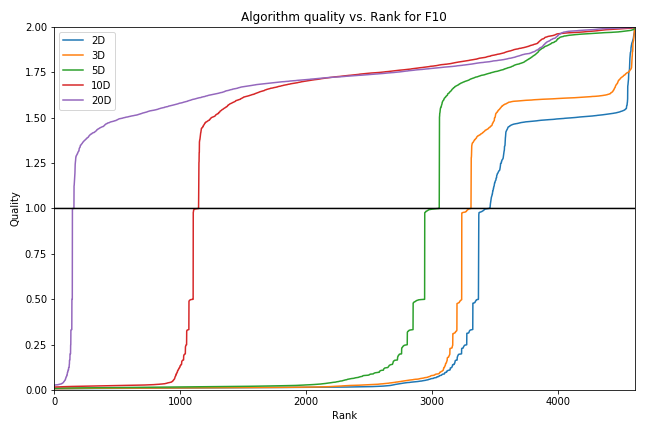

In [4]:
Image(filename='plots/q-measures_f10.png')  # An example

# Decision Trees

Because configurations consist of 11 choices (i.e. "should this module be on or off?"),
decision trees are a very natural first step into visualizing what it means to include a module.

Each tree is created by giving the module configuration as the decision variables,
and the $q$-measure as the prediction value.

## Full size trees

In [5]:
features = modules

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)  
        graph.write_png(plot_dir + "regressor_tree_{}_f{}.{}".format(dim, fid, plot_format))

As you can tell, these trees are way too big. There is basically no useful way to read
anything from these trees.

Let's try smaller trees instead:

## Small trees

In [6]:
features = modules

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(max_depth=4, min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png(plot_dir + "small_regressor_tree_{}_f{}.{}".format(dim, fid, plot_format))

In [7]:
features = modules

best_x = 250

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=20, min_samples_leaf=10)
        clf = clf.fit(cases[dim][fid][:best_x,:11], cases[dim][fid][:best_x,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png(plot_dir + "best_{}_regressor_tree_{}_f{}.{}".format(best_x, dim, fid, plot_format))

When using smaller trees, it is much easier to see what is going on, and which module has any influence.
However, there are still just too many of them to quickly get a good idea of what's happening.

Besides, how good are these trees anyway? We need some numerical measures
to get a better idea of how useful these trees are.

## Cross-validation score

In [8]:
scores = {dim: np.zeros(len(fids)) for dim in dims}
np.set_printoptions(precision=2, linewidth=200)

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        scores[dim][fid-1] = np.mean(cross_val_score(clf, cases[dim][fid][:,:11], cases[dim][fid][:,11], cv=20))

print(" 2D:", scores[2])
print(" 3D:", scores[3])
print(" 5D:", scores[5])
print("10D:", scores[10])
print("20D:", scores[20])

 2D: [ 0.65  0.91  0.81  0.45  0.9   0.95  0.61  0.91  0.91  0.92  0.92  0.92  0.93  0.91  0.83  0.85  0.87  0.81  0.88  0.74  0.8   0.91  0.87  0.37]
 3D: [ 0.45  0.94  0.61  0.16  0.98  0.92  0.81  0.93  0.92  0.93  0.92  0.95  0.91  0.94  0.66  0.8   0.8   0.65  0.33  0.4   0.89  0.92  0.63  0.4 ]
 5D: [ 0.79  0.87  0.22  0.52  0.92  0.78  0.84  0.79  0.8   0.83  0.82  0.86  0.84  0.84  0.32  0.56  0.63  0.47  0.51 -0.02  0.46  0.56  0.12  0.89]
10D: [ 0.82  0.6   0.68  0.84  0.84  0.61  0.78  0.74  0.76  0.51 -0.6   0.82  0.42  0.86  0.63  0.64  0.7   0.77  0.85  0.83  0.71  0.49  0.8   0.84]
20D: [ 0.87  0.8   0.67  0.69  0.85  0.58  0.64  0.69  0.74  0.77  0.1   0.83  0.73  0.83  0.68  0.89  0.74  0.78  0.8  -2.57  0.76  0.25  0.84  0.82]


Higher values mean a tree provides a good prediction/classification of the $q$-measure
value based on the configuration. It's clear that some trees are good, but others not so much.

This still doesn't give any information about what each _module_ is doing to the performance.
To get an idea of this, we can calculate so-called _feature importance_ for each module.

## Feature Importance based on Regressor Trees

First create a large number of random decision trees (e.g. 250).
Feature_importance scores can be easily retrieved as `forest.feature_importances_`

These scores are calculated based on how often and high up the tree each feature is used
for splitting a node. Based on an example from the official [documentation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [9]:
all_importances = np.zeros((len(dims), len(fids), len(modules)))

for i_dim, dim in enumerate(dims):
    for i_fid, fid in enumerate(fids):
        forest = ExtraTreesRegressor(n_estimators=250, min_samples_leaf=20)
        forest = forest.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        all_importances[i_dim,i_fid,:] = forest.feature_importances_

In [10]:
feature_importances = np.mean(np.mean(all_importances, axis=0), axis=0)
feature_indices = np.argsort(feature_importances)[::-1]

# Print the feature importances
print("Feature importances:")
for f in range(len(feature_indices)):
    print("{0: <12} | {1}".format(modules[f], feature_importances[f]))

Feature importances:
Active       | 0.066728096624
Elitism      | 0.224437984633
Mirrored     | 0.0129439303872
Orthogonal   | 0.0102273153961
Sequential   | 0.0349093344034
Threshold    | 0.305224211445
TPA          | 0.137357856663
Pairwise     | 0.0693702405324
Weights      | 0.0535074321997
Base-Sampler | 0.0212128047673
(B)IPOP      | 0.0640807929485


# Relative Activation Frequency

To get an idea of how frequent a certain module is chosen, the cumulative sum versus the ranking can be plotted. This works because a configuration consists purely of 0's, 1's and occaisionally 2's. As all possible configurations have been tested, the total sum will always end up at the same fixed value. For the first 9 modules with options 0 and 1 each, the total will always be 2304\*0 + 2304\*1 = 2304, while for the last two modules with options 0, 1 and 2, the total will be 1536\*0 + 1536\*1 + 1536\*2 = 4608.

Such a plot already shows if some modules are chosen more often than others, but as they are all constantly increasing and very bunched together, it is hard to see the interesting details.

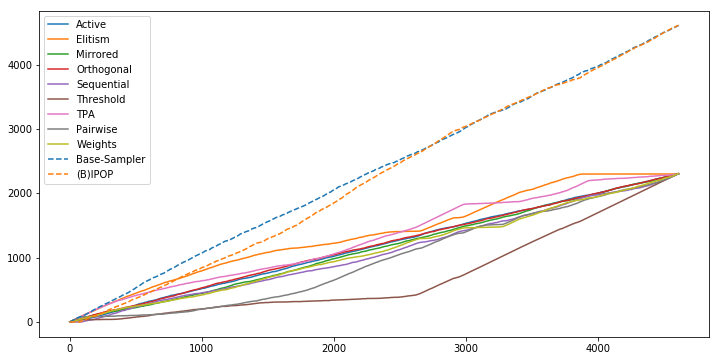

In [11]:
# Starting with the 'default' cumsum plot...

plt.figure(figsize=(12, 6))
lines = plt.plot(np.cumsum(cases[2][1][cases[2][1][:,11].argsort()][:,:11], axis=0))
plt.legend(lines, modules)
plt.show()

So instead we can normalize the values. We start by making all values 0 or 1, so we just count activations. After all, there is no reason for option 2 to be twice as important compared to option 1 for the relevant modules.

Next, we are interested in how a module performs compared to the minimum or maximum possible value at that time. As an example: for a module which has been activated in 100 cases, it matters a lot if that has happened in the first 100 or first 1000 configurations. So, we determine the maximum and minimum possible values for any given rank and use those to calculate the distance between them.

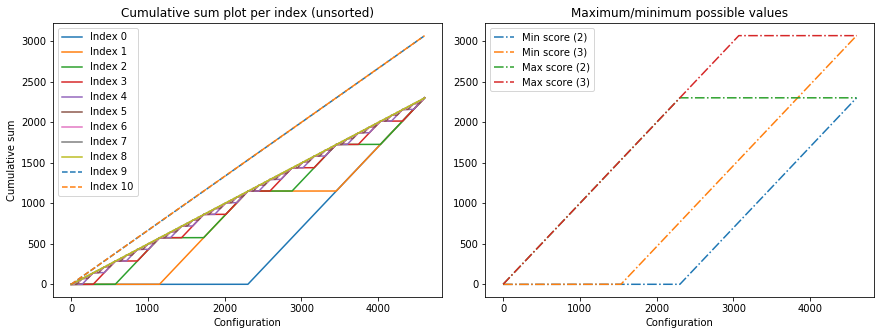

In [12]:
# Create normalization vectors for module progression plots

min_column = [0] * 2304
min_column.extend(range(1,2305))
min_column = np.array(min_column).reshape((4608,1))

max_column = range(1, 2305)
max_column.extend([2304] * 2304)
max_column = np.array(max_column).reshape((4608,1))

min_columns = np.repeat(min_column, 9, axis=1)
max_columns = np.repeat(max_column, 9, axis=1)


min_column = [0] * 1536
min_column.extend(range(1, 3073))
min_column = np.array(min_column).reshape((4608,1))

max_column = range(1, 3073)
max_column.extend([3072] * 1536)
max_column = np.array(max_column).reshape((4608,1))

min_columns = np.hstack((min_columns, min_column, min_column))
max_columns = np.hstack((max_columns, max_column, max_column))

dists = max_columns - min_columns
dists[-1,:] = 1  # Prevent division by 0

# Test/comparison for confirmation!
temp = cases[2][1][:,:11].copy()

# replace all values '2' with '1'
two_indices = temp == 2
temp[two_indices] = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes([0.025, 0.05, 0.45, 0.95])
ax1.set_title("Cumulative sum plot per index (unsorted)")
ax1.set_ylabel("Cumulative sum")
ax1.set_xlabel("Configuration")
lines = ax1.plot(np.cumsum(temp, axis=0))
ax1.legend(lines, ['Index {}'.format(i) for i in range(11)])

ax2 = fig.add_axes([0.525, 0.05, 0.45, 0.95])
ax2.set_xlabel("Configuration")
ax2.set_title("Maximum/minimum possible values")
lines = ax2.plot(min_columns[:,8:10], '-.')
lines2 = ax2.plot(max_columns[:,8:10], '-.')
lines.extend(lines2)
ax2.legend(lines, ['Min score (2)', 'Min score (3)', 'Max score (2)', 'Max score (3)'])
plt.show()

With these distances in place, we can normalize each value by subtracting the minimum and dividing by the distance. This way, we see for each module at each rank, how often it is active in the top-$n$ ranks as a fraction of how often it could have been active.

In short, this means that a line at the top of the plot will have been active in all the best-ranked configurations, while one at the bottom will have been active in none of them. When it is simply random, the line will hover around 0,5.

In [13]:
# Define the plot as a function to be called again easily

def create_relative_activation_plot(dim, fid):
    temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,:11].copy()

    # replace all values '2' with '1'
    two_indices = temp == 2
    temp[two_indices] = 1

    temp = np.cumsum(temp, axis=0)
    temp = temp - min_columns
    temp = temp / dists

    cutoff = 100

    plt.figure(figsize=(10, 4))
    plt.suptitle("Progression for {}D F{}".format(dim, fid))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 

    ax1 = plt.subplot(gs[0])
    ax1.plot(temp[:cutoff+1,:])
    ax1.set_xlim([0, cutoff])
    ax1.set_ylabel('Relative activation frequency')

    ax2 = plt.subplot(gs[1], sharey=ax1)
    lines = ax2.plot(temp[cutoff//2:,:])
    ax2.set_xlim([cutoff//2,4608])
    ax2.set_xlabel('Rank')

    plt.tight_layout()

    plt.subplots_adjust(wspace=0, hspace=0, top=0.88)

    # Shrink current axis by 15%
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.75, box.height])

    # Put a legend to the right of the current axis
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=lines, labels=modules)

    plt.savefig(plot_dir + "module_progression_{}_f{}.{}".format(dim, fid, plot_format))

    plt.close()

In [14]:
# Create and save plots for all experiments

for dim in dims:
    for fid in fids:
        create_relative_activation_plot(dim, fid)

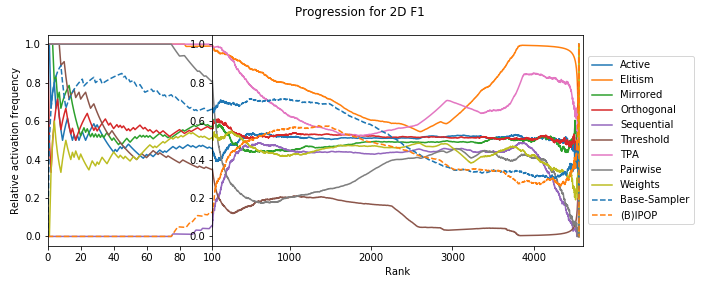

In [15]:
Image(filename='plots/module_progression_2_f1.png')  # An example

# Correlation scores

If we consider the *Relative Activation Frequency* plots from the previous section to be the 'behavior' of a module in a particular experiment, then it is interesting to compare behaviors between modules and experiments.

First, let's just calculate all Pearson R correlations between all behaviors.

In [16]:
# Calculate all correlations into 'correlations[5, 24, 11, 5, 24, 11]'

correlations = np.zeros((5, 24, 11, 5, 24, 11))
data = {x: {} for x in range(len(dims))}
labels = list(product(dims, fids, modules))

for a_dim, dim in enumerate(dims):
    for a_fid, fid in enumerate(fids):
        temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,:11].copy()
    
        # replace all values '2' with '1'
        two_indices = temp == 2
        temp[two_indices] = 1
    
        temp = np.cumsum(temp, axis=0)
        temp = temp - min_columns
        temp = temp / dists
        
        data[a_dim][a_fid] = temp

for a_dim, _ in enumerate(dims):
    for a_fid, _ in enumerate(fids):
        for a_mod in range(len(modules)):
            for b_dim, _ in enumerate(dims):
                for b_fid, _ in enumerate(fids):
                    for b_mod in range(len(modules)):
                        correlations[a_dim, a_fid, a_mod, b_dim, b_fid, b_mod] = pearsonr(data[a_dim][a_fid][:, a_mod], data[b_dim][b_fid][:, b_mod])[0]

## Visualisations

Let's take a look at this data. In total we have (5\*24\*11)^2 correlation values (actually half of that because of symmetry). If these correlation values are just randomly distributed, a histogram should easily show this. Two Gaussian distributions are plotted for comparison: a regular and truncated variant. For more information on the truncated Gaussian, please refer to the relevant SciPy [documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.truncnorm.html).

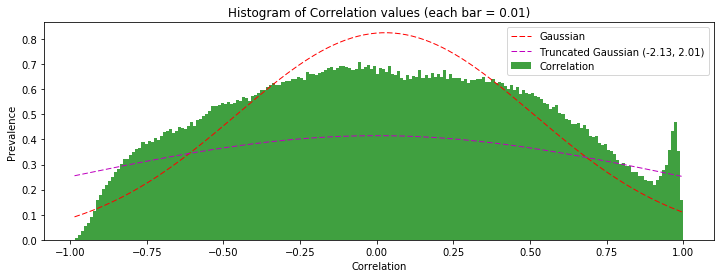

In [17]:
# Visualize the distribution of correlation values as a histogram (+ expected gaussian to see if they are actually interesting)

x = correlations.reshape((len(dims)*len(fids)*len(modules)*len(dims)*len(fids)*len(modules), ))
mu = np.mean(x)
std = np.std(x)

plt.figure(figsize=(12,4))
plt.title('Histogram of Correlation values (each bar = 0.01)')
n, bins, patches = plt.hist(x, 200, normed=1, facecolor='green', alpha=0.75, label='Correlation')
y = mlab.normpdf(bins, mu, std)
l = plt.plot(bins, y, 'r--', linewidth=1, label='Gaussian')

a, b = (-1 - mu) / std, (1 - mu) / std
tn = truncnorm(a, b)
y = tn.pdf(bins)
l = plt.plot(bins, y, 'm--', linewidth=1, label='Truncated Gaussian (-2.13, 2.01)')
plt.xlabel('Correlation')
plt.ylabel('Prevalence')
plt.legend(loc=0)
plt.show()

It is clear that there is indeed a peak of highly correlated behaviors that is not explained by the Gaussian distributions. We can investigate further by plotting the correlations as a heatmap, albeit a rather large one.

In [18]:
# Create one giant heatmap (1320*1320)

x = np.arange(len(dims)*len(fids)*len(modules) + 1)
y = np.arange(len(dims)*len(fids)*len(modules) + 1)
X, Y = np.meshgrid(x, y)

temp_corr = correlations.reshape((len(dims)*len(fids)*len(modules), len(dims)*len(fids)*len(modules)))


plt.figure(figsize=(16,12))
plt.pcolor(X, Y, temp_corr, cmap='viridis', vmin=-1, vmax=1)
plt.title("Inter-module behavior correlation")
plt.colorbar(label='Correlation')
plt.xlim([0,len(dims)*len(fids)*len(modules)])
plt.ylim([0,len(dims)*len(fids)*len(modules)])
plt.tight_layout()
plt.savefig(plot_dir + "correlation_heatmap.{}".format(plot_format))
plt.close()

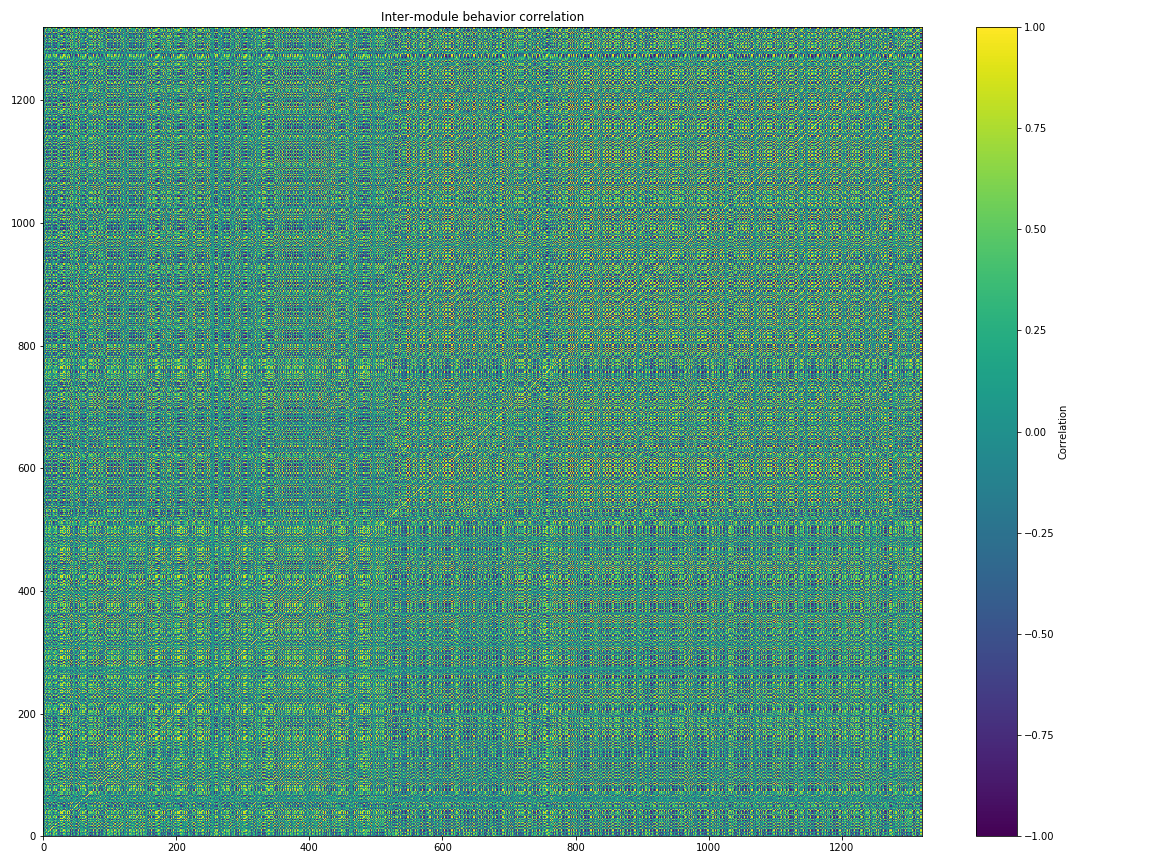

In [19]:
Image(filename="plots/correlation_heatmap.png")

This is too big to see anything in besides maybe a vague similarity related to dimensionality.

Besides, it is hard to argue what most of these values actually mean: what is the information in the correlation between different modules for different experiments?
More useful information is probably shown if these correlations are separately plotted per module.

In [20]:
# Create heatmaps per module (120*120)

x = np.arange(len(dims)*len(fids) + 1)
y = np.arange(len(dims)*len(fids) + 1)
X, Y = np.meshgrid(x, y)

temp_corr = correlations.reshape((len(dims)*len(fids), len(modules), len(dims)*len(fids), len(modules)))

tick_locations = [0.5, 11.5, 24.5, 35.5, 48.5, 59.5, 72.5, 83.5, 96.5, 107.5, 119.5]
tick_labels = ['2D F1', '2D F12', '3D F1', '3D F12', '5D F1', '5D F12', '10D F1', '10D F12', '20D F1', '20D F12', '20D F24']

for mod in range(11):
    plt.figure(figsize=(8,6))
    plt.pcolor(X, Y, temp_corr[:,mod,:,mod], cmap='viridis', vmin=-1, vmax=1)
    plt.title("Behavior correlation for module '{}'".format(modules[mod]))
    plt.xlabel('Experiment')
    plt.ylabel('Experiment')
    plt.xticks(tick_locations, tick_labels, rotation='vertical')
    plt.yticks(tick_locations, tick_labels)
    plt.colorbar(label='Correlation')
    plt.tight_layout()
    plt.savefig(plot_dir + "correlation_heatmap_{}.{}".format(modules[mod], plot_format))
    plt.close()

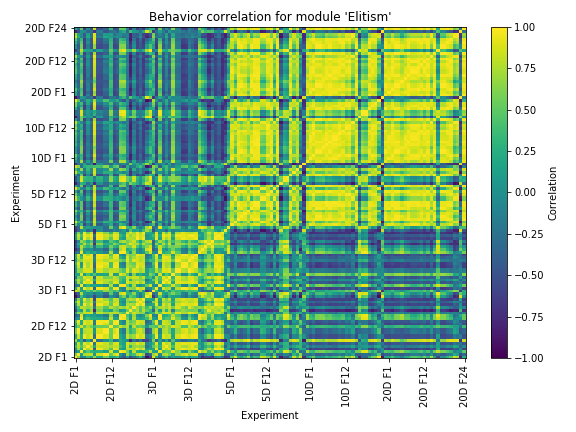

In [21]:
Image(filename="plots/correlation_heatmap_Elitism.png")

A 120\*120 heatmap is still fairly large, but at least all values are now meaningful. The vague dimensionality correlation we saw earlier is also much more present this time.

## Clustering by Correlation

The previous heatmaps suggest that there are some (small) groups of behaviors that correlate highly with each other. Let's find out what clusters of cases we find if we create and plot clusters of highly correlating behaviors.

To create the clusters, we use the [NetworkX](https://networkx.github.io/) package to create a network of all behaviors as nodes, where we only add edges between them if their correlation is high enough. You can see below that the code for this is very simple.

In [22]:
# Cluster creation function definition. Creates clusters by making a graph out of all (dim, fid, mod) pairs that are correlated

def cluster_correlation_as_components(corr, corr_filter=0.99, min_size=3):
    temp = np.triu(corr.reshape((1320, 1320)), k=1)

    high_corr = temp > corr_filter
    high_corr_ind = np.argwhere(high_corr)

    G = nx.Graph()
    G.add_edges_from(high_corr_ind)
    print("Number of edges:                ", len(high_corr_ind))
    print("Number of connected components: ", nx.number_connected_components(G))
    print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

    clusters = [c for c in sorted(nx.connected_components(G), key=len, reverse=True) if len(c) >= min_size]
    print(len(clusters))
    
    return clusters

In [23]:
# Cluster plotting function definition

def create_and_save_progression_clusters(clusters, corr_vals, cluster_type='', ignore_triples=False, legend_limit=10):
    if len(cluster_type) > 0:
        
        if cluster_type == 'naive':
            title_name = 'naive'
        elif cluster_type == 'mod-coop':
            title_name = 'module cooperation'
        elif cluster_type == 'exp-sim':
            title_name = 'experiment similarity'
        else:
            title_name = cluster_type
        
        cluster_type = cluster_type + '_'

    cutoff = 100
    for clust_num, cluster in enumerate(clusters):

        cluster_corr_indices = np.array(list(combinations([case for case in cluster], 2)))
        cluster_corr_vals = [corr_vals.reshape((1320, 1320))[a, b] for a, b in cluster_corr_indices]
        min_corr_val = np.min(cluster_corr_vals)
        
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
        plt.figure(figsize=(7.5, 3))
        plt.suptitle("Progression for {0} cluster (c > {1:.3f})".format(title_name, min_corr_val))

        clust_labels = []
        clust_lines = []
        for case in cluster:
            dim, fid, mod = labels[case]
            if ignore_triples is True and mod in ['Base-Sampler', '(B)IPOP']:
                continue

            mod = modules.index(mod)
            temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,mod].copy()
            temp[temp == 2] = 1  # replace all values '2' with '1'

            temp = np.cumsum(temp, axis=0)
            temp = temp - min_columns[:,mod]
            temp = temp / dists[:,mod]

            ax1 = plt.subplot(gs[0])
            ax1.plot(temp[:cutoff+1])
            ax2 = plt.subplot(gs[1], sharey=ax1)
            
            clust_lines.extend(ax2.plot(temp[cutoff//2:]))
            clust_labels.append("{} ({}D F{})".format(modules[mod], dim, fid))

        ax1.set_xlim([0, cutoff])
        ax1.set_ylim([0,1])
        ax1.set_ylabel('Relative activation frequency')
        ax2.set_xlim([cutoff//2,4608])
        ax2.set_xlabel('Rank')

        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0, top=0.88)

        if len(cluster) < legend_limit:
            ax2.legend(loc=0, handles=clust_lines, labels=clust_labels)

        plt.savefig(plot_dir + "module_progression_{}cluster_{}_{}.{}".format(cluster_type, clust_num, len(clusters), plot_format))

        plt.close()

There are two kinds of clusters that can be considered useful:

 - Module Cooperations
 - Experiment similarities

For module cooperation, we keep the experiment the same, and see if there are modules that behave similarly. If two modules are activated in (roughly) the same order, their cooperation  probably has a positive influence on the optimization process.

Alternatively, we can look for experiment similarity by clustering behavior of the same module over multiple experiments. If a module behaves similarly for multiple experiments, their fitness landscapes are probably related.

### Module Cooperation clustering

In [24]:
# Create clusters on 'Module Cooperation'
print("Module Cooperation (experiment fixed)")

# Create a copy of all correlation values artificially reduced by 1
mod_coop_corr = correlations.copy() - 1

# Restore the correct correlation values of all cases we are actually interested in
for dim in range(len(dims)):
    for fid in range(len(fids)):
        mod_coop_corr[dim, fid, :, dim, fid, :] = mod_coop_corr[dim, fid, :, dim, fid, :] + 1

mod_coop_filter_val = 0.9
mod_coop_clusters = cluster_correlation_as_components(mod_coop_corr, corr_filter=mod_coop_filter_val, min_size=2)

Module Cooperation (experiment fixed)
Number of edges:                 124
Number of connected components:  110
[4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
110


In [25]:
# Create clustered progression plots
create_and_save_progression_clusters(mod_coop_clusters, mod_coop_corr, 'mod-coop')

### Experiment Similarity Clustering

In [26]:
# Create clusters on 'Experiment Similarity'
print("Experiment similarity (module fixed)")

# Create a copy of all correlation values artificially reduced by 1
exp_sim_corr = correlations.copy() - 1

# Restore the correct correlation values of all cases we are actually interested in
for mod in range(len(modules)):
    exp_sim_corr[:, :, mod, :, :, mod] = exp_sim_corr[:, :, mod, :, :, mod] + 1

exp_sim_filter_val = 0.9925
exp_sim_clusters = cluster_correlation_as_components(exp_sim_corr, corr_filter=exp_sim_filter_val)

Experiment similarity (module fixed)
Number of edges:                 276
Number of connected components:  61
[57, 15, 9, 8, 6, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
17


In [27]:
# Create clustered progression plots
create_and_save_progression_clusters(exp_sim_clusters, exp_sim_corr, 'exp-sim')

# Impact scores

## Single module

Now let's use the $q$-measure from earlier to calculate a numerical *impact* of a module. To do this, we calculate the average $q$-value for all configurations with a module *on* and *off*. By subtracting one from the other, we get a numerical value that indicates how big the impact of a module being active is.

This numerical value is not the only thing of importance though. After all, this impact score is calculated as a difference between two sets, so it is only natural to wonder if this difference is statistically significant. As can already be somewhat seen in the $q$-measure plots, we cannot assume that these $q$-values are distributed normally, so for the statistical test we use the two-tailed [Mann-Whitney U test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html).

First we'll have a look at the impact of *individual* modules, averaged over all 120 experiments. This means that we actually want to create two large sets, one set *on* and another one *off* for each module. For the impact score it would not matter, but averaging the statistical significances of each experiment would make no sense. This cell will also calculate the significance and impact per experiment/module combination and store them, just because we're already creating the subsets for each separate case anyway. These values are used further on.

In [28]:
single_impact = np.zeros((len(dims), len(fids), len(modules)))
single_significance = np.zeros((len(dims), len(fids), len(modules)))
impact_calc_data = {dim: {fid: {} for fid in fids} for dim in dims}

for i_dim, dim in enumerate(dims):
    for fid in fids:
        temp = cases[dim][fid]
        
        for mod in range(len(modules)):
            indices_on = temp[:,mod] > 0
            indices_off = temp[:,mod] < 1

            impact_calc_data[dim][fid][mod] = (temp[indices_on,11], temp[indices_off,11])
            
            mean_on = np.mean(temp[indices_on,11])
            mean_off = np.mean(temp[indices_off,11])
            
            single_impact[i_dim, fid-1, mod] = mean_off - mean_on
            single_significance[i_dim, fid-1, mod] = mannwhitneyu(temp[indices_on,11],
                                                                  temp[indices_off,11],
                                                                  alternative='two-sided')[1]

print("Module name  | Impact             p-value")
print("-------------|--------------------------------------")
for mod in range(len(modules)):
    data_on, data_off = zip(*[impact_calc_data[dim][fid][mod] for dim in dims for fid in fids])
    data_on = np.array(data_on).reshape((-1,1))
    data_off = np.array(data_off).reshape((-1,1))
    
    total_impact = np.mean(data_off) - np.mean(data_on)
    total_p_value = mannwhitneyu(data_on, data_off, alternative='two-sided')[1]
    
    print("{0: <12} | {1: <16}   {2: <20}".format(modules[mod],
          total_impact, total_p_value))

Module name  | Impact             p-value
-------------|--------------------------------------
Active       | -0.12603970585     0.0                 
Elitism      | 0.274163653035     0.0                 
Mirrored     | 0.0113576646795    6.60541546106e-10   
Orthogonal   | 0.022634543826     8.71737223597e-43   
Sequential   | -0.102557959514    0.0                 
Threshold    | -0.491054282784    0.0                 
TPA          | 0.070425108658     0.0                 
Pairwise     | -0.0275808280011   3.13207131766e-43   
Weights      | -0.121672952006    0.0                 
Base-Sampler | 0.0175724305012    1.1801609164e-15    
(B)IPOP      | 0.103844054609     0.0                 


This is the clearest generic information we now have on these separate modules: what their impact is compared to a [0,2] scale, and the statistical significance of that value. Especially the very low p-values are a great result! The lower impact values such as 0.01 for *Mirrored* should of course be taken with a grain of salt, but impact scores for *Elitism* and *Threshold* really stand out.

Next step is to separate the information out into the 120 different experiments, as we can only learn so much from the aggregate. Let's create a scatter-plot of the impact vs. significance for each of the 120\*11 = 1320 experiment/module combinations:

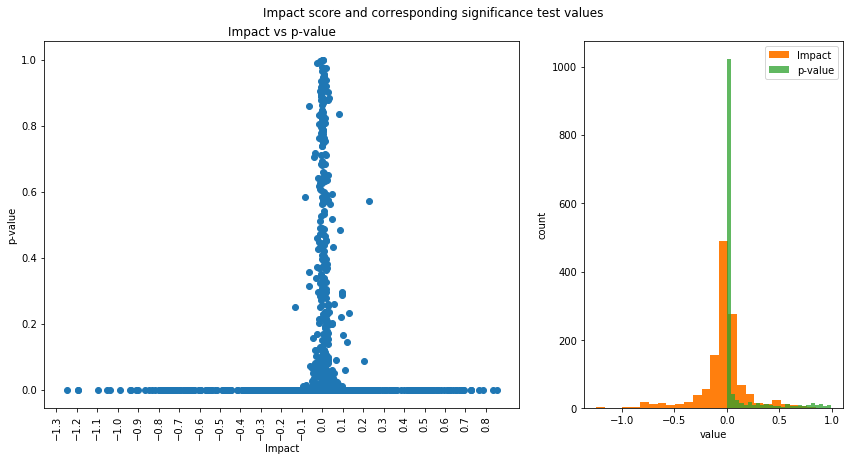

In [29]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Impact score and corresponding significance test values')

ax1 = fig.add_axes([0.05, 0.05, 0.55, 0.85])
ax1.set_title('Impact vs p-value')
ax1.scatter(single_impact.reshape((-1,1)), single_significance.reshape((-1,1)))
ax1.set_xlabel('Impact')
ax1.set_ylabel('p-value')
ax1.set_xticks(np.arange(-1.3, 0.9, 0.1))
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90)

ax2 = fig.add_axes([0.675, 0.05, 0.3, 0.85])
ax2.set_xlabel('value')
ax2.set_ylabel('count')
ax2.hist(single_impact.reshape((-1,1)), 25, facecolor='#ff7f0e', label='Impact')
ax2.hist(single_significance.reshape((-1,1)), 25, facecolor='#2ca02c', alpha=0.75, label='p-value')
ax2.legend(loc=0)

plt.savefig(plot_dir + "impact_vs_p-value.{}".format(plot_format))
plt.show()

Especially in the additional histogram, it is clear that most p-values are quite small. Another good sign!

Through trial and error we can probably figure the range of impact values corresponding to all the p-values over 0.05. This way we can easily say that all impact values below or above certain values are always significant.

In [30]:
imps = single_impact.reshape((-1,1))
sigs = single_significance.reshape((-1,1))

# The following values are the result of trial and error. You're welcome!
neg_imps_A = imps < -.132
neg_imps_B = imps < -.133

pos_imps_A = imps > .228
pos_imps_B = imps > .229

print("Max p-value:            p = {} from {} values".format(max(sigs)[0], len(sigs)))
print()

print("Max p-value I < -0.132: p = {} from {} values".format(max(sigs[neg_imps_A]), len(sigs[neg_imps_A])))
print("Max p-value I < -0.133: p = {} from {} values".format(max(sigs[neg_imps_B]), len(sigs[neg_imps_B])))

print()

print("Max p-value I >  0.228: p = {} from {} values".format(max(sigs[pos_imps_A]), len(sigs[pos_imps_A])))
print("Max p-value I >  0.229: p = {} from {} values".format(max(sigs[pos_imps_B]), len(sigs[pos_imps_B])))

Max p-value:            p = 0.999929318648 from 1320 values

Max p-value I < -0.132: p = 0.249701547004 from 234 values
Max p-value I < -0.133: p = 7.6305619424e-05 from 231 values

Max p-value I >  0.228: p = 0.57191485249 from 95 values
Max p-value I >  0.229: p = 1.14446551582e-12 from 93 values


It seems that the 324 impact values below -0.133 and above 0.229 are all statistically significant for $p < 10^{-4}$, so that's good news too.

Now we know that also the individual impact values make some sense, the easiest way to visualize them is probably with a heatmap, so we'll make one for each of the modules. 

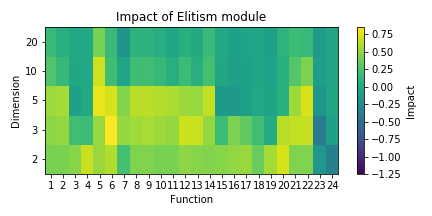

In [31]:
x = np.arange(len(fids)+1)
y = np.arange(len(dims)+1)
X, Y = np.meshgrid(x, y)

minval = np.min(single_impact)
maxval = np.max(single_impact)

for mod in range(len(modules)):
    plt.figure(figsize=(6,3))
    plt.pcolor(X, Y, single_impact[:,:,mod], cmap='viridis', vmin=minval, vmax=maxval)
    plt.title("Impact of {} module".format(modules[mod]))
    plt.colorbar(label='Impact')
    plt.xlim([0,24])
    plt.ylabel("Dimension")
    plt.yticks([.5, 1.5, 2.5, 3.5, 4.5], ['2', '3', '5', '10', '20'])
    plt.xticks(np.arange(len(fids))+.5, np.arange(len(fids))+1)
    plt.xlabel("Function")
    plt.tight_layout()
    plt.savefig(plot_dir + "impact_heatmap_{}.{}".format(modules[mod], plot_format))
    plt.close()

Image(filename='plots/impact_heatmap_Elitism.png')

## Module interaction

The impact calculations we did above can be done for any two sets of configurations. So to determine the impact of a *combination* of modules, all we have to do is determine two other sets of configurations. For the combination set, this means the *on* set of configurations in which both modules are active, and the *off* set of everything else (think logical `AND` and `NAND` on the activation indices).

In [32]:
interaction_impact = np.zeros((len(dims), len(fids), len(modules), len(modules)))
interaction_significance = np.zeros((len(dims), len(fids), len(modules), len(modules)))

for i_dim, dim in enumerate(dims):
    for fid in fids:
        temp = cases[dim][fid]
        
        for A_mod in range(len(modules)):
            A_indices_on = temp[:,A_mod] > 0
            
            for B_mod in range(len(modules)):
                B_indices_on = temp[:,B_mod] > 0

                indices_on = np.logical_and(A_indices_on, B_indices_on)  # A AND B
                indices_off = np.logical_not(indices_on)                 # A NAND B == NOT (A AND B)

                mean_on = np.mean(temp[indices_on,11])
                mean_off = np.mean(temp[indices_off,11])

                interaction_impact[i_dim, fid-1, A_mod, B_mod] = mean_off - mean_on
                interaction_significance[i_dim, fid-1, A_mod, B_mod] = mannwhitneyu(temp[indices_on,11],
                                                                                    temp[indices_off,11],
                                                                                    alternative='two-sided')[1]

Similar to the single module analysis earlier, let's see what the spread of impact vs. p-value looks like to give an idea of how reliable the results are.

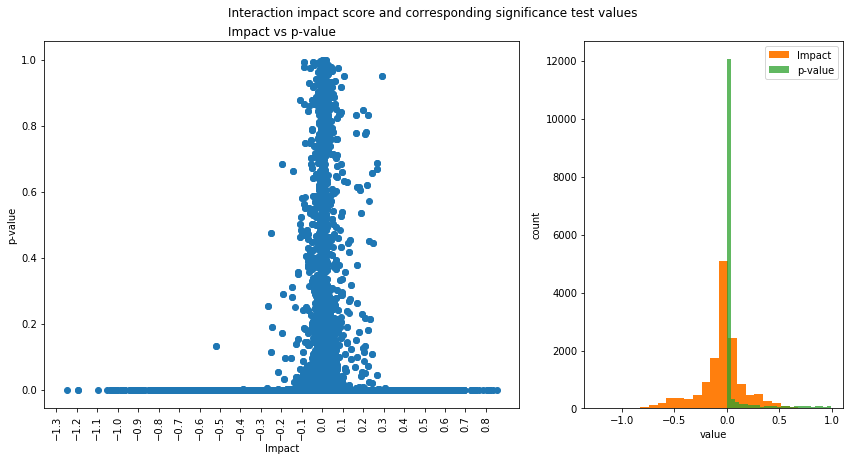

In [33]:
# Interaction impact vs p-value

fig = plt.figure(figsize=(12,6))
fig.suptitle('Interaction impact score and corresponding significance test values')

ax1 = fig.add_axes([0.05, 0.05, 0.55, 0.85])
ax1.set_title('Impact vs p-value')
ax1.scatter(interaction_impact.reshape((-1,1)), interaction_significance.reshape((-1,1)), label='\'nand\' Impact')
ax1.set_xlabel('Impact')
ax1.set_ylabel('p-value')
ax1.set_xticks(np.arange(-1.3, 0.9, 0.1))
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90)

ax2 = fig.add_axes([0.675, 0.05, 0.3, 0.85])
ax2.set_xlabel('value')
ax2.set_ylabel('count')
ax2.hist(interaction_impact.reshape((-1,1)), 25, facecolor='#ff7f0e', label='Impact')
ax2.hist(interaction_significance.reshape((-1,1)), 25, facecolor='#2ca02c', alpha=0.75, label='p-value')
ax2.legend(loc=0)

plt.savefig(plot_dir + "interaction_impact_vs_p-value.{}".format(plot_format))
plt.show()

In [34]:
# Some statistics about the occurring p-values

interaction_imps = interaction_impact.reshape((-1,1))
interaction_sigs = interaction_significance.reshape((-1,1))

sig_level = 0.01
interaction_sig = interaction_sigs < sig_level

print("Number of significant nand values (p < {}): {}/{} values".format(sig_level, len(interaction_sigs[interaction_sig]), len(interaction_sigs)))

Number of significant nand values (p < 0.01): 11535/14520 values


As could be expected, this is similar to the results in the single module case. At least this means we can generally be confident in drawing conclusions from the heatmaps we are about to create.

In these cases, the interaction between the modules is most important, so we create 11\*11 heatmaps.

In [35]:
def create_and_save_interaction_impact(impacts, vmin=None, vmax=None, save=True, show=False, cmap='viridis',
                                       extra_save_info='', title=None):

    x = np.arange(len(modules)+1)
    y = np.arange(len(modules)+1)
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize=(5,4))
    
    if title is not None:
        plt.title(title)
    
    plt.pcolor(X, Y, impacts, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(label='Module Interaction Impact')
    plt.xlim([0,len(modules)])
    plt.ylim([0,len(modules)])
    plt.xticks(np.arange(len(modules)) + 0.5, modules, rotation=45, horizontalalignment='right')
    plt.yticks(np.arange(len(modules)) + 0.5, modules)
    plt.tight_layout()
    
    if save:
        plt.savefig(plot_dir + "interaction_impact_heatmap{}.{}".format(extra_save_info, plot_format))
    
    if show:
        plt.show()
    else:
        plt.close()

First up: impacts averaged over all 120 experiments.

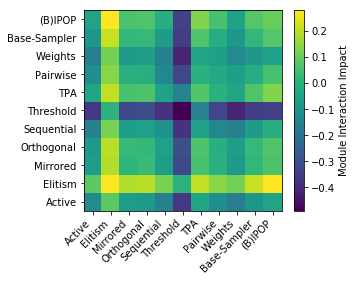

In [36]:
create_and_save_interaction_impact(np.mean(np.mean(interaction_impact, axis=0), axis=0), save=True, show=True)

Next: the same heatmaps, but separated for each function. This means that the values are still averaged over all tested dimensionalities. When comparing different functions, it is useful to have the colorbar in the same scale. However, when differences for a single function are small, it's better to just let the colorbar represent all impact values in just that plot. To be on the safe side, we plot them both. All plots using the same values are plotted using the `viridis` colormap, the others using the `plasma` colormap.

In [37]:
minval = np.min(np.mean(interaction_impact, axis=0))
maxval = np.max(np.mean(interaction_impact, axis=0))

for fid in range(len(fids)):
    create_and_save_interaction_impact(np.mean(interaction_impact[:,fid,:,:], axis=0), vmin=minval, vmax=maxval,
                                       extra_save_info='_f{}'.format(fids[fid]),
                                       title="Impact of module interaction for F{}".format(fids[fid]))

    create_and_save_interaction_impact(np.mean(interaction_impact[:,fid,:,:], axis=0), cmap='plasma',
                                       extra_save_info='_f{}_plasma'.format(fids[fid]),
                                       title="Impact of module interaction for F{}".format(fids[fid]))

Finally, we repeat the process for each separate experiment. Again with the two different versions of the same plot, based on the scaling of the colormap.

In [38]:
minval = np.min(interaction_impact)
maxval = np.max(interaction_impact)

for dim in range(len(dims)):
    for fid in range(len(fids)):
        create_and_save_interaction_impact(interaction_impact[dim,fid,:,:], vmin=minval, vmax=maxval,
                                           extra_save_info='_{}_f{}'.format(dims[dim], fids[fid]),
                                           title="Impact of module interaction for {}D F{}".format(dims[dim], fids[fid]))

        create_and_save_interaction_impact(interaction_impact[dim,fid,:,:], cmap='plasma',
                                           extra_save_info='_{}_f{}_plasma'.format(dims[dim], fids[fid]),
                                           title="Impact of module interaction for {}D F{}".format(dims[dim], fids[fid]))

That's it! This is the analysis we performed, and should be exactly reproducible. If there are any problems, suggestions or remarks, feel free to mail me.